In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import itertools

#For model building
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#For Metrics evaluation 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    
    if min_val == max_val:
        # Handle the case where all values are the same to avoid division by zero
        return [0.0] * len(input_list)
    
    normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    
    return normalized_list

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data = train_data.drop(['policy_id'], axis=1)

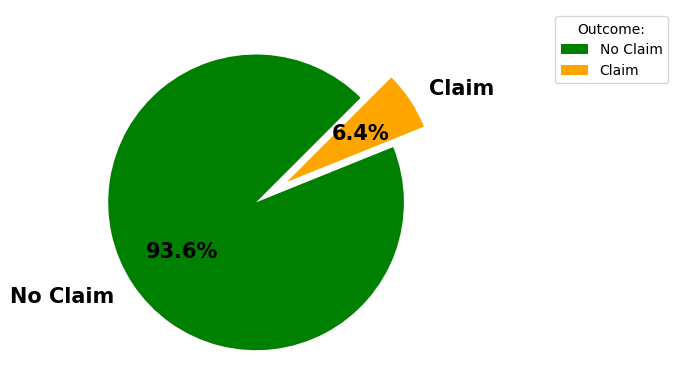

In [4]:
fig = plt.figure(facecolor='white')

ax = fig.add_subplot(1, 1, 1, facecolor='white')

plt.pie(train_data['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})

plt.legend(title='Outcome:', loc='upper right', bbox_to_anchor=(1.6, 1))

fig.patch.set_facecolor('white')

plt.show()

In [5]:
train_data['max_torque'].value_counts()
train_data['torque'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
train_data['rpm'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
train_data['torque'] = pd.to_numeric(train_data['torque'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate torque to RPM ratio 
train_data['torque to rpm ratio'] = train_data['torque'] / train_data['rpm']

In [6]:
# Deleting redundant columns from training set
train_data.drop('max_torque', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('torque',axis=1,inplace=True)

In [7]:
train_data['max_power'].value_counts()

max_power
88.50bhp@6000rpm     17796
40.36bhp@6000rpm     14948
113.45bhp@4000rpm    14018
55.92bhp@5300rpm      4173
67.06bhp@5500rpm      2373
97.89bhp@3600rpm      2114
88.77bhp@4000rpm      1598
61.68bhp@6000rpm      1209
118.36bhp@5500rpm      363
Name: count, dtype: int64

In [8]:
train_data['power'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
train_data['rpm'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

# Convert the columns to numeric data type
train_data['power'] = pd.to_numeric(train_data['power'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate power to RPM ratio
train_data['power to rpm ratio'] = train_data['power'] / train_data['rpm']

In [9]:
train_data.drop('power', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('max_power',axis=1,inplace=True)

In [10]:
is_cols=[col for col in train_data.columns if col.startswith("is") and col!="is_claim"]
print(is_cols)

['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [11]:
train_data = train_data.replace({ "No" : 0 , "Yes" : 1 })

In [12]:
dataset_num_col = train_data.select_dtypes(include=['int', 'float']).columns
print(" Data Set Numerical columns:")
print(dataset_num_col.nunique())
print(dataset_num_col)

 Data Set Numerical columns:
35
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim',
       'torque to rpm ratio', 'power to rpm ratio'],
      dtype='object')


In [13]:
dataset_cat_cols = train_data.select_dtypes(include=['object']).columns
print("Data Set categorical columns:")
print(dataset_cat_cols.nunique())
print(dataset_cat_cols)

Data Set categorical columns:
8
Index(['area_cluster', 'segment', 'model', 'fuel_type', 'engine_type',
       'rear_brakes_type', 'transmission_type', 'steering_type'],
      dtype='object')


In [14]:
train_data= pd.get_dummies(train_data, columns=dataset_cat_cols,drop_first=True)


In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

def imbalanced_data(X_data, y_data):
    
    minority_class, majority_class = y_data.value_counts().sort_values().values
    print('\033[1m' + "Before Over Sampling" + '\033[0m')
    print(f"\nShape of the data : {X_data.shape}\n\nValue Counts\n{y_data.value_counts()}")
    
    if (minority_class * 2) > majority_class:
        print("Data is Balanced")
    else:
        print(f"\nData is Imbalanced")
        print('\n\033[1m' + "After Over Sampling" + '\033[0m\n')
        X_data, y_data = SMOTE().fit_resample(X_data, y_data)
        print(f"Shape of the data : {X_data.shape}\n\nValue Counts\n{y_data.value_counts()}")
        
    return X_data, y_data
y = train_data['is_claim']
train_data, y = imbalanced_data(train_data, y)

Before Over Sampling

Shape of the data : (58592, 87)

Value Counts
is_claim
0    54844
1     3748
Name: count, dtype: int64

Data is Imbalanced

After Over Sampling

Shape of the data : (109688, 87)

Value Counts
is_claim
0    54844
1    54844
Name: count, dtype: int64


In [16]:
X = train_data.drop(['is_claim'], axis=1)  # Features

In [17]:
#分割train:val:test = 8:1:1
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

In [18]:
#檢查分割資料數據是否balance
y_train.value_counts(),y_val.value_counts(),y_test.value_counts()

(is_claim
 0    43875
 1    43875
 Name: count, dtype: int64,
 is_claim
 1    5485
 0    5484
 Name: count, dtype: int64,
 is_claim
 0    5485
 1    5484
 Name: count, dtype: int64)

In [19]:
boolean_columns = X_train.select_dtypes(include=['bool']).columns

In [20]:
for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_val[i] = X_val[i].astype(int)
    X_test[i] = X_test[i].astype(int)

In [21]:
X_train_df = X_train.copy()
X_val_df = X_val.copy()
X_test_df = X_test.copy()

In [22]:
from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

###########################2.1~2.2開始###########################

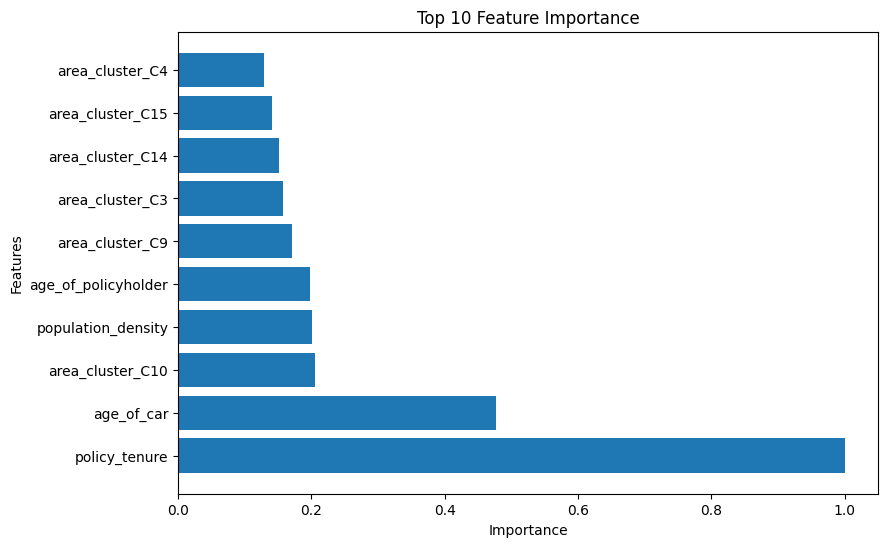

['policy_tenure', 'age_of_car', 'area_cluster_C10', 'population_density', 'age_of_policyholder', 'area_cluster_C9', 'area_cluster_C3', 'area_cluster_C14', 'area_cluster_C15', 'area_cluster_C4']


In [23]:
import model

classifier = model.LinearClassifier()
classifier.fit(X_train, y_train, X_val, y_val, re=False)
importance = classifier.get_feature_importance()

feature_names = list(X_train_df.columns)
len(feature_names),len(importance)
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

sorted_importance = normalize_list(sorted_importance)

top_n = len([value for i, value in enumerate(sorted_importance) if value > 0.12])
top_n = 10

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_importance[:top_n], tick_label=sorted_feature_names[:top_n])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.subplots_adjust(left=0.2) 
plt.savefig("Linear Feature Importance.jpg")
plt.show()

print(sorted_feature_names[:top_n])
classifier_feature = sorted_feature_names[:top_n]

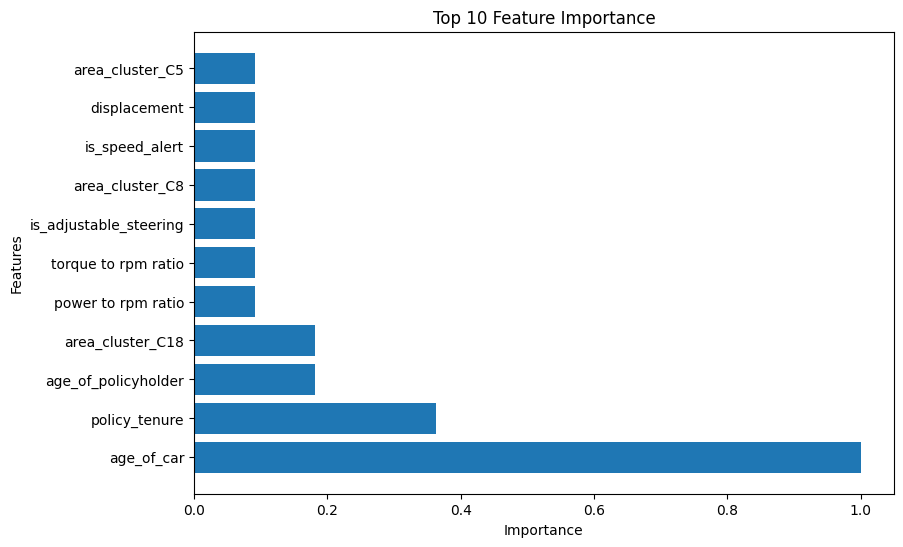

['age_of_car', 'policy_tenure', 'age_of_policyholder', 'area_cluster_C18', 'power to rpm ratio', 'torque to rpm ratio', 'is_adjustable_steering', 'area_cluster_C8', 'is_speed_alert', 'displacement', 'area_cluster_C5']


In [24]:
import model

Ptree = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
Ptree.fit(X_train, y_train)
importance = Ptree.feature_importance(X_train, y_train)  # Pass your feature matrix 'X_train' and target vector 'y_train'
feature_names = list(X_train_df.columns)
len(feature_names),len(importance)
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

sorted_importance = normalize_list(sorted_importance)

top_n = len([value for i, value in enumerate(sorted_importance) if value > 0.01])

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_importance[:top_n], tick_label=sorted_feature_names[:top_n])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.subplots_adjust(left=0.2) 
plt.savefig("Decision Tree Feature Importance.jpg")
plt.show()

print(sorted_feature_names[:top_n])
tree_feature = sorted_feature_names[:top_n]

PermutationExplainer explainer: 87751it [52:46, 27.62it/s]                             


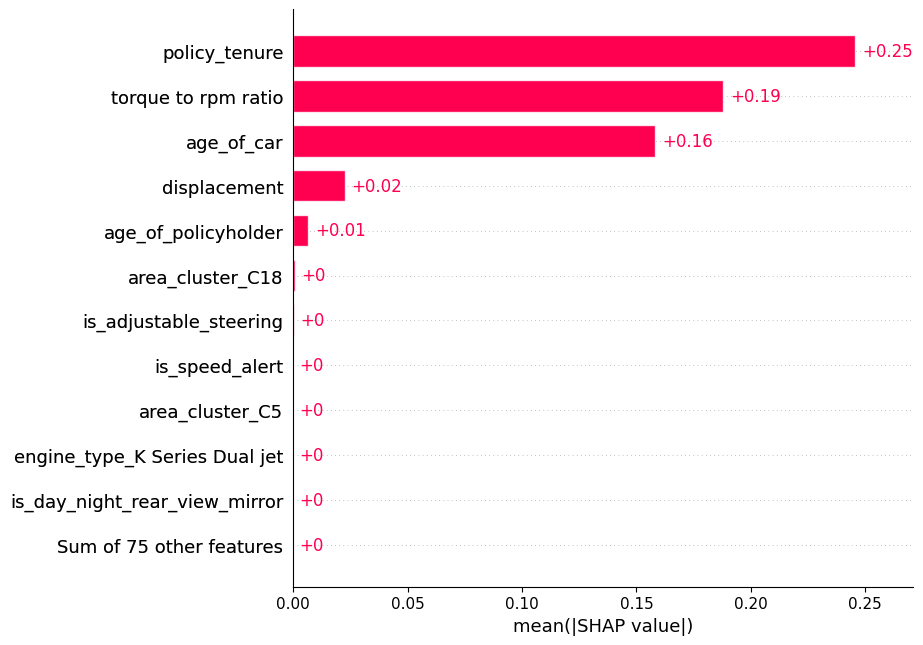

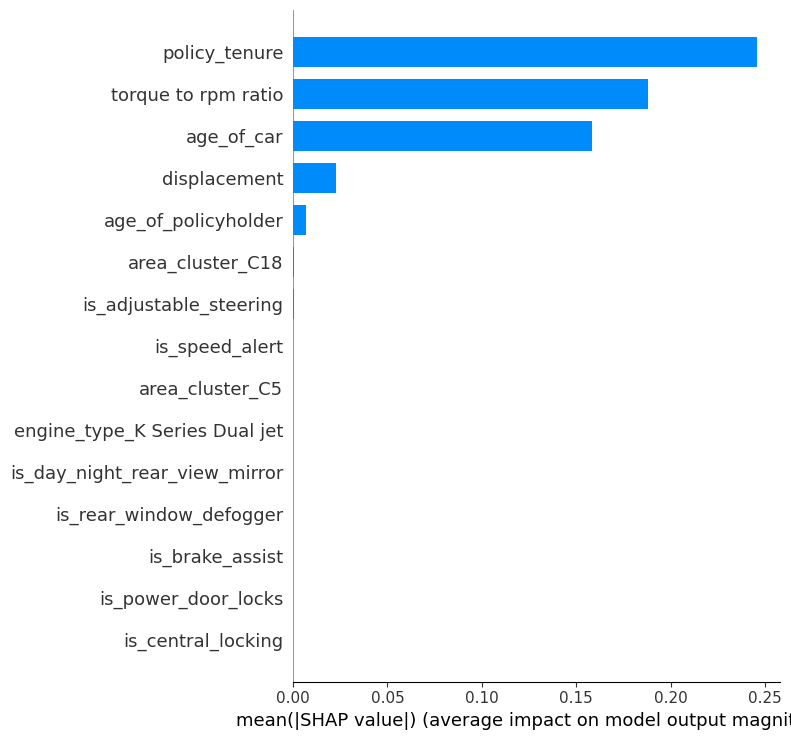

In [25]:
import shap

# train DecisionTree model
# model = model.DecisionTreeClassifier(max_depth=5, min_samples_split=2)
# model.fit(X_train, y_train)
# compute SHAP values
explainer = shap.Explainer(Ptree.predict, X_train)
explainer.feature_names = feature_names
shap_values = explainer(X_train)

# Summarize the effects of features
shap.plots.bar(shap_values, max_display=12)

shap.summary_plot(shap_values, X_train, plot_type="bar",show=False, max_display=15)
plt.savefig('shap.png')

###########################2.1~2.2結束###########################

In [26]:
#特徵篩選
merged_feature_list = list(set(classifier_feature + tree_feature))
X = X[merged_feature_list]

#分割train:val:test = 8:1:1
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

boolean_columns = X_train.select_dtypes(include=['bool']).columns

for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_val[i] = X_val[i].astype(int)
    X_test[i] = X_test[i].astype(int)

X_train_df = X_train.copy()
X_val_df = X_val.copy()
X_test_df = X_test.copy()

from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

(87750, 18) (10969, 18) (10969, 18)


###########################1.1~1.4開始###########################

第1次訓練
Training Accuracy: 0.5
第2次訓練
Training Accuracy: 0.5728547008547008
第3次訓練
Training Accuracy: 0.572957264957265
第4次訓練
Training Accuracy: 0.5728205128205128
第5次訓練
Training Accuracy: 0.5727065527065527
第6次訓練
Training Accuracy: 0.5727977207977208
第7次訓練
Training Accuracy: 0.5728774928774929
第8次訓練
Training Accuracy: 0.5729116809116809
第9次訓練
Training Accuracy: 0.5728205128205128
第10次訓練
Training Accuracy: 0.5728774928774929
第11次訓練
Training Accuracy: 0.5727749287749287
第12次訓練
Training Accuracy: 0.5727635327635328
第13次訓練
Training Accuracy: 0.5726495726495726
第14次訓練
Training Accuracy: 0.5726267806267806
第15次訓練
Training Accuracy: 0.5725128205128205
第16次訓練
Training Accuracy: 0.5724672364672365
第17次訓練
Training Accuracy: 0.5725356125356126
第18次訓練
Training Accuracy: 0.5724444444444444
第19次訓練
Training Accuracy: 0.5724330484330484
第20次訓練
Training Accuracy: 0.5725128205128205
第21次訓練
Training Accuracy: 0.5725242165242165
第22次訓練
Training Accuracy: 0.5725128205128205
第23次訓練
Training Accuracy: 0.5725242

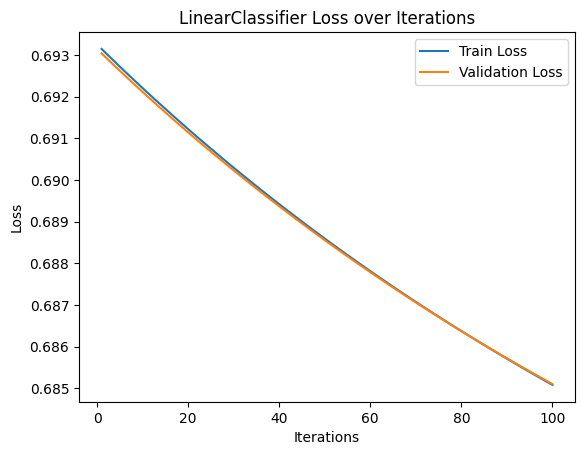

In [27]:
import model
classifier = model.LinearClassifier()
classifier.fit(X_train, y_train, X_val, y_val)
classifier_y_val_pred = classifier.predict(X_val)
print ("\nThe Val Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_val, classifier_y_val_pred))

classifier_y_test_pred = classifier.predict(X_test)
print ("\nThe Test Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_test, classifier_y_test_pred))
classifier.plot_loss(save_path="LinearClassifier_loss_plot.png") 

In [28]:
import model
knn = model.kNN()
knn.fit(X_train, y_train.to_numpy())
knn_y_val_pred = knn.predict(X_val)
print ("\nThe Val Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_val, knn_y_val_pred))

knn_y_test_pred = knn.predict(X_test)
print ("\nThe Test Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_test, knn_y_test_pred))


The Val Accuracy of our Knn is: 0.7984319445710639

The Test Accuracy of our Knn is: 0.7915033275594858


In [29]:
import model
import time

t1 = time.time()
tree = model.DecisionTreeClassifier()  # 設置樹的最大深度
tree.fit(X_train, y_train)
print(time.time()-t1)
print("開始預測")
tree_y_val_pred = tree.predict(X_val)
print ("\nThe Val Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_val, tree_y_val_pred))

tree_y_test_pred = tree.predict(X_test)
print ("\nThe Test Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_test, tree_y_test_pred))

33.767393589019775
開始預測

The Val Accuracy of our classifier is: 0.5720667335217431

The Test Accuracy of our classifier is: 0.5643176223903729


In [30]:
import model
import time

t1 = time.time()
Ptree = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
Ptree.fit(X_train, y_train)
print(time.time()-t1)
print("開始預測")
Ptree_y_val_pred = Ptree.predict(X_val)
print ("\nThe Val Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_val, Ptree_y_val_pred))

Ptree_y_test_pred = Ptree.predict(X_test)
print ("\nThe Test Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_test, Ptree_y_test_pred))

1.4632065296173096
開始預測

The Val Accuracy of our classifier is: 0.6097182970188714

The Test Accuracy of our classifier is: 0.5971373871820586


###########################1.1~1.4結束###########################

###########################2.3開始###########################

In [31]:
#New Feature
X_stacked = np.array([classifier_y_val_pred, knn_y_val_pred, tree_y_val_pred, Ptree_y_val_pred]).T

Stacking_tree = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
Stacking_tree.fit(X_stacked, y_val)
print("開始預測")
stack_tree_y_val_pred = Stacking_tree.predict(X_stacked)
print ("\nThe Val Accuracy of our new feature is:", sklearn.metrics.accuracy_score(y_val, stack_tree_y_val_pred))

print ("\nThe Val Accuracy of our old feature is:", sklearn.metrics.accuracy_score(y_val, Ptree_y_val_pred))


開始預測

The Val Accuracy of our new feature is: 0.7986142765976844

The Val Accuracy of our old feature is: 0.6097182970188714


###########################2.3結束###########################

In [32]:
# import pickle
# # 保存模型到文件
# with open('decision_tree_model.pkl', 'wb') as model_file:
#     pickle.dump(tree1, model_file)

# # 加载保存的模型
# with open('decision_tree_model.pkl', 'rb') as model_file:
#     tree1 = pickle.load(model_file)

# print("開始預測")
# y_val_pred = tree1.predict(X_val)
# print ("\nThe Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_val, y_val_pred))

# y_test_pred = tree1.predict(X_test)
# print ("\nThe Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_test, y_test_pred))